In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.solvers.neuralDistDDE_with_adjoint as nddde
import src.bio_eqn_case.bio_eqn as bio

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Define some useful classes

### Class for user-defined arguments

In [4]:
class bio_eq_nDistDDE_args(nddde.nddde_arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1, nn_d1 = 0., nn_d2 = 0.5, adj_data_size = 2,
                 model_dir = 'Bio_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2000., nt = 4000, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                    Xi = 0.1, R_m = 1., Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30, bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD', isplot = True): # add more arguments as needed
        
        if bio_model_low_complex == 'NPZ': state_dim = 3
        elif bio_model_low_complex == 'NPZD': state_dim = 4
        elif bio_model_low_complex == 'NNPZD': state_dim = 5

        nddde.nddde_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, nn_d1 = nn_d1,
                           nn_d2 = nn_d2, state_dim = state_dim, adj_data_size = state_dim, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot)

        bio.bio_eqn_args.__init__(self, T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_low_complex)
        
        self.bio_args_for_high_complex = bio.bio_eqn_args(T = T, nt = nt, z = z, k_w = k_w, alpha = alpha, V_m = V_m, I_0 = I_0, K_u = K_u, Psi = Psi,
                    Xi = Xi, R_m = R_m, Lambda = Lambda, gamma = gamma, Tau = Tau, Phi = Phi, Omega = Omega, T_bio = T_bio, bio_model = bio_model_high_complex)
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex

### Define the neural net architecture

In [5]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(7, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(7, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    def call(self, z):
        for i in range(len(self.layers)):
            z = self.layers[i](z)
        return z

In [6]:
class DDEFuncAux(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncAux, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

        self.out = tf.keras.layers.Dense(4, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    def call(self, z):
        for i in range(len(self.layers)):
            z = self.layers[i](z)
        return z

In [7]:
class split_zy:
    def __init__(self, zy, args):
        self.zy = zy
        self.args = args

    def __call__(self, t):
        return self.zy(t)[:, :self.args.state_dim]

In [8]:
class DistDDEFunc:

    def __init__(self, main, aux, rom_model, args):
        self.main = main
        self.aux = aux
        self.rom_model = rom_model
        self.args = args

    def __call__(self, y, t ,d):
        
        get_z = split_zy(y, self.args)       

        dz_dt = self.main(y(t)) + self.rom_model(get_z, t)
        gz_t1 = self.aux(y(t - d[0])[:, :self.args.state_dim])
        gz_t2 = self.aux(y(t - d[1])[:, :self.args.state_dim])
        dy_dt = gz_t1 - gz_t2
        return tf.concat([dz_dt, dy_dt], axis=-1)

### Define a custom plotting function

In [9]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(6, 4), facecolor='white')
        ax_x1 = fig.add_subplot(111)

        ax_x1.cla()
        ax_x1.set_title('Bio Variables', fontsize=14)
        ax_x1.set_xlabel('t', fontsize=14)
        ax_x1.set_ylabel('Concentration', fontsize=14)
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 0], '-r', label = 'N (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 0], '-.r', label = 'N (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 0], '--r', label = 'N (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 1], '-g', label = 'P (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 1], '-.g', label = 'P (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 1], '--g', label = 'P (Learned)')
        ax_x1.plot(self.t.numpy(), self.true_y.numpy()[:, 0, 2], '-b', label = 'Z (NNPZD)')
        ax_x1.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, 2], '-.b', label = 'Z (NPZ)')
        ax_x1.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, 2], '--b', label = 'Z (Learned)')

        ax_x1.set_xlim(self.t[0], self.t[-1])
        ax_x1.set_ylim(0., self.args.T_bio)
        ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

        plt.show() 

### Initial Conditions

In [10]:
class initial_cond:

    def __init__(self, app):
        self.app = app

    def __call__(self, t):

        if self.app.bio_model == 'NPZ':
            x0 = [self.app.T_bio - 0.5*2, 0.5, 0.5]
        elif self.app.bio_model == 'NPZD':
            x0 = [self.app.T_bio - 0.5*2, 0.5, 0.5, 0.]
        elif self.app.bio_model == 'NNPZD':
            x0 = [self.app.T_bio/2., self.app.T_bio/2. - 2*0.5, 0.5, 0.5, 0.]
        return tf.convert_to_tensor([x0], dtype=tf.float32)

### Initialize model related parameters

In [11]:
args = bio_eq_nDistDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 8, epochs = 500, learning_rate = 0.05, decay_rate = 0.97, test_freq = 1, plot_freq = 1,
                    d_max = 3., nn_d1 = 0., nn_d2 = 2.0, model_dir = 'Bio_nDistDDE_testcase/model_dir_case47', restart = 1, val_percentage = 1.,
                    T = 20., nt = 400, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                    Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30., bio_model_low_complex = 'NPZ', bio_model_high_complex = 'NNPZD')

### Make a copy of the current script

In [12]:
os.chdir(basedir)

checkpoint_dir_main = os.path.join(args.model_dir, "ckpt_main")
checkpoint_dir_aux = os.path.join(args.model_dir, "ckpt_aux")
checkpoint_prefix_main = os.path.join(checkpoint_dir_main, "cp-{epoch:04d}.ckpt")
checkpoint_prefix_aux = os.path.join(checkpoint_dir_aux, "cp-{epoch:04d}.ckpt")

### Solve for the high complexity model

In [13]:
t = tf.linspace(0., args.T, args.nt) # Time array

x0_high_complex = initial_cond(args.bio_args_for_high_complex) # Initial conditions

x_high_complex = ddeinttf(bio.bio_eqn(args.bio_args_for_high_complex), x0_high_complex, t)

# Compute FOM for the validation time
dt = t[1] - t[0]
val_t_len =  args.val_percentage * (t[-1] - t[0])
n_val = np.ceil(np.abs(val_t_len/dt.numpy())).astype(int)
val_t = tf.linspace(t[-1], t[-1] + val_t_len, n_val)

val_x_high_complex = ddeinttf(bio.bio_eqn(args.bio_args_for_high_complex), nddde.create_interpolator(x_high_complex, t), val_t)

print('Higher complexity model done!')

/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


Higher complexity model done!


### Transform states of high complexity model to low complexity model

In [14]:
# Create modes for the training and validation period combined
true_x_low_complex = bio.convert_high_complex_to_low_complex_states(x_high_complex, args)

x0_low_complex = initial_cond(args)


Solve the low complexity model

In [15]:
x_low_complex = ddeinttf(bio.bio_eqn(args), x0_low_complex, t)

val_x_low_complex = ddeinttf(bio.bio_eqn(args), nddde.create_interpolator(x_low_complex, t), val_t)

#### Create validation set

In [16]:
val_obj = nddde.create_validation_set_nddde(x0_low_complex, t, args)

val_true_x_low_complex = bio.convert_high_complex_to_low_complex_states(val_x_high_complex, args)

## Main part starts here

### Make objects and define learning-rate schedule

In [17]:
func_main = DDEFuncMain()
func_aux = DDEFuncAux()
func = DistDDEFunc(func_main, func_aux, bio.bio_eqn(app = args), args)

### Quick test to see how the true coefficients looks like

In [18]:
func_main.load_weights(tf.train.latest_checkpoint(checkpoint_dir_main))
func_aux.load_weights(tf.train.latest_checkpoint(checkpoint_dir_aux))
process_true_z0 = nddde.process_DistDDE_IC(x0_low_complex, func_aux, t_lowerlim = t[0] - args.nn_d2, t_upperlim = t[0] - args.nn_d1)
pred_zy = ddeinttf(func, process_true_z0, tf.concat([t, val_t], axis=0), fargs=([args.nn_d1, args.nn_d2],))

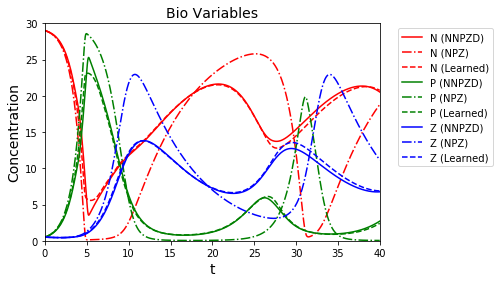

In [19]:
plot_obj = custom_plot(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), tf.concat([x_low_complex, val_x_low_complex], axis=0), 
                       tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_zy[:, :, :args.state_dim])

### Print the network architecture

In [20]:
func_main.summary()

Model: "dde_func_main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  56        
_________________________________________________________________
dense_1 (Dense)              multiple                  56        
_________________________________________________________________
dense_2 (Dense)              multiple                  24        
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________


In [21]:
func_aux.summary()

Model: "dde_func_aux"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  20        
_________________________________________________________________
dense_4 (Dense)              multiple                  30        
_________________________________________________________________
dense_5 (Dense)              multiple                  24        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________
